In [37]:
!pip install wordcloud


In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# Loading the data Set

df=pd.read_csv(r'Ukraine_10K_tweets.csv')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10167 entries, 0 to 10166
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tweet         9999 non-null   object 
 1   polarity      9999 non-null   float64
 2   subjectivity  9999 non-null   float64
 3   Sentiment     9999 non-null   object 
dtypes: float64(2), object(2)
memory usage: 317.8+ KB



Since both polarity and subjectivity are calculated based on other models so to make our own model lets drop them

In [41]:
df=df.drop(['polarity','subjectivity'],axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10167 entries, 0 to 10166
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9999 non-null   object
 1   Sentiment  9999 non-null   object
dtypes: object(2)
memory usage: 159.0+ KB


In [43]:
df.head()

,Tweet,Sentiment
0,RT @ChristopherJM: Zelensky also confirms CIA ...,Negative
1,RT @oryxspioenkop: Russia acquired these vehic...,Positive
2,RT @RepMTG: I’m calling for an audit of every ...,Positive
3,"RT @KyivIndependent: ""Russian goal seems to be...",Negative
4,RT @william98161886: I see Rishi just given an...,Positive


In [44]:
# there are null values so it is not preferably to handle values

In [45]:
has_nulls = df[df.isnull().any(axis=1)]
print(has_nulls.isnull().all(axis=1).count())
print(has_nulls.shape[0])

168
168


In [46]:
df.dropna(inplace=True)

Lets preprocess the tweets so that there is no links and other unnecessary information

In [47]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

(-0.5, 799.5, 399.5, -0.5)

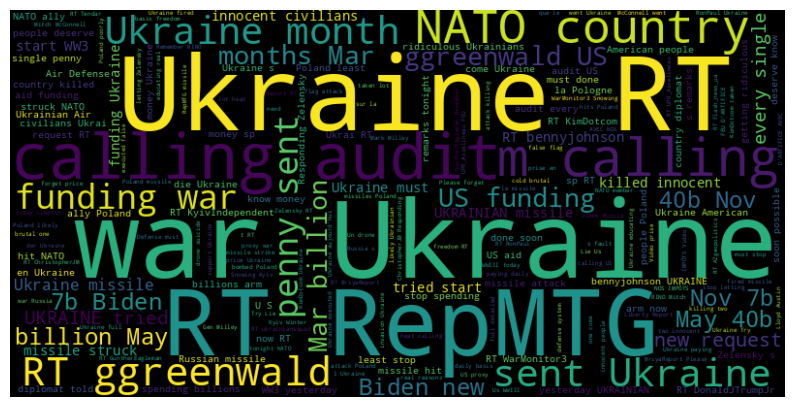

In [48]:
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords


all_tweets = ' '.join(df['Tweet'])
stop_words = set(stopwords.words('english'))
filtered_tweets = ' '.join(word for word in all_tweets.split() if word.lower() not in stop_words and not re.match(r'https?://[^\s]+', word.lower()))

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(filtered_tweets)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

Here we are first joining all the tweets and setting the stop words and then filtering the tweets so that all the words in the stop words are not removed and there fore removing links

In [49]:
# Need to remove stop words and url components
cleaned_tweets = df['Tweet']
stop_words = set(stopwords.words('english'))

def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'https?://[^\s]+', '', tweet)
    # Remove stop words
    tweet = ' '.join(word for word in tweet.split() if word.lower() not in stop_words)
    return tweet

cleaned_tweets = cleaned_tweets.apply(preprocess_tweet)
df['Tweet'] = cleaned_tweets
df.head()

,Tweet,Sentiment
0,RT @ChristopherJM: Zelensky also confirms CIA ...,Negative
1,RT @oryxspioenkop: Russia acquired vehicles se...,Positive
2,RT @RepMTG: I’m calling audit every single pen...,Positive
3,"RT @KyivIndependent: ""Russian goal seems entre...",Negative
4,RT @william98161886: see Rishi given another 4...,Positive


In [50]:
df['Sentiment'] = df['Sentiment'].map({'Positive': 1, 'Negative': 0})
df.head()

,Tweet,Sentiment
0,RT @ChristopherJM: Zelensky also confirms CIA ...,0
1,RT @oryxspioenkop: Russia acquired vehicles se...,1
2,RT @RepMTG: I’m calling audit every single pen...,1
3,"RT @KyivIndependent: ""Russian goal seems entre...",0
4,RT @william98161886: see Rishi given another 4...,1


In [51]:
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
0    7935
1    2064
Name: count, dtype: int64


In [52]:
X = df['Tweet']
y = df['Sentiment']

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X = tfidf_vectorizer.fit_transform(X)

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
random_forest.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest.predict(X_test)

In [56]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 97.60%


In [57]:
# Display additional metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3180
           1       0.99      0.89      0.94       820

    accuracy                           0.98      4000
   macro avg       0.98      0.94      0.96      4000
weighted avg       0.98      0.98      0.98      4000

